In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import qualified Data.Text as T
import Control.Arrow (first,second)
import Control.Monad
import Graphics.Vega.VegaLite hiding (density)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced.Static

:l Plotting.hs


We'll start with the example of a simple regression

In [2]:
paramPriorRegression = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 4 4
    return (slope, intercept, noise)


regressionData :: (MonadSample m, Traversable t) => t Double -> m (t (Double, Double))
regressionData xs = do
    (slope, intercept, noise) <- paramPriorRegression
    forM xs \x -> do
        y <- normal (x*slope + intercept) (sqrt noise)
        return (x, y)

In [3]:
range = [-10,-9.9..10] :: [Double]
regressionSamples <- sampleIOfixed $ regressionData range

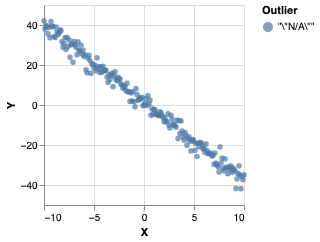

In [4]:
plotVega (fmap (second (T.pack . show)) (zip regressionSamples (Prelude.repeat "N/A")))

In [5]:
regression :: (MonadInfer m) => [Double] -> [Double] -> m (Double, Double, Double)
regression xs ys = do
    params@(slope, intercept, noise) <- paramPriorRegression
    forM (zip xs ys) \(x, y) -> factor $ normalPdf (slope * x + intercept) (sqrt noise) y
    return (slope, intercept, noise)

mhRunsRegression <- sampleIOfixed $ prior $  mh 1000 $ regression range (snd <$> regressionSamples)


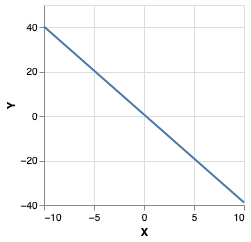

In [6]:
plotVega (range, (\(s,i,_) -> (s,i)) $ head mhRunsRegression) 


This is a sample from the MCMC walk. Since this is an easy inference problem, it wasn't hard to generate good samples.

We can also view the posterior predictive, as follows:

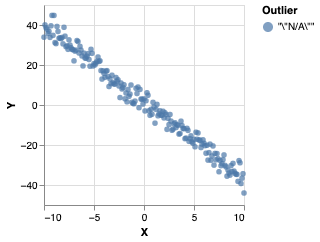

In [7]:
posteriorPredictive :: MonadInfer m => [Double] -> [Double] -> m [Double]
posteriorPredictive xs ys = do
    (slope, intercept, noise) <- regression xs ys
    forM xs \x -> do
            let y' = x * slope + intercept
            normal y' (sqrt noise)


predictive <- head <$> (sampleIOfixed $ prior $ mh 1000 $ posteriorPredictive range (snd <$> regressionSamples))
plotVega (fmap (second (T.pack . show)) (zip (zip range predictive) (Prelude.repeat "N/A")))


Inspired by the tutorials on probabilistic programming language Gen (https://www.gen.dev/tutorials/iterative-inference/tutorial), we'll make the inference problem harder by using the example of a regression with outliers. The idea is that each datapoint $(x,y)$ has $y$ either linearly dependent on $x$, or randomly sampled (an outlier). So the goal of inference is to *jointly* work out what the linear relationship is and which points flout it.

In [25]:
paramPrior = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 4 4
    prob_outlier <- uniform 0 0.5 
    return (slope, intercept, noise, prob_outlier)

forward (slope, intercept, noise, probOutlier) x = do
    isOutlier <- bernoulli probOutlier
    let meanParams = if isOutlier
                    then (0, 20)
                    else (x*slope + intercept, sqrt noise)
    return (meanParams, isOutlier)

regressionWithOutliersData :: (MonadSample m, Traversable t) => t Double -> m (t ((Double, Double), Bool))
regressionWithOutliersData xs = do
    params <- paramPrior

    forM xs \x -> do
        ((mu, std), isOutlier) <- forward params x
        y <- normal mu std
        return ((x, y), isOutlier)

This is our model. It describes a process for getting $y$ from $x$. Specifically, you start by drawing values for the slope $s$, bias $b$ and noise $n$. Then for each input $x$, you flip a coin. If it lands one way, you draw a $y$ value from a normal with mean $x*slope + bias$ and std $n$, and otherwise you draw from a centered normal with large variance.

Given a list of $x$ values, this gives a distribution over lists of $y$ values, from which we can sample:




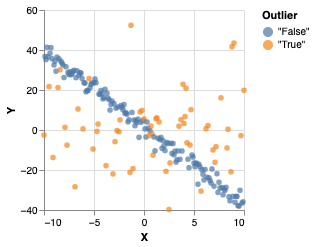

In [26]:
range = [-10,-9.9..10] :: [Double]
samples <- sampleIOfixed $ regressionWithOutliersData range
plotVega (fmap (second (T.pack . show)) samples)


This is our dataset, with outliers shown in orange.

Given this dataset of $(x,y)$ pairs, we now consider the problem of inference. That is, we want to infer the slope, bias, noise and *for each datapoint*, whether it's an outlier.

Our first attempt will be to average a large number of samples, weighted by how likely they are. TODO: add the conditioning


Why did this result in a bad guess? Simply because there are so many more bad guesses than good ones, so that even if you weight the good guesses higher, if you have almost none, then it doesn't matter.

The classic solution to this problem (the solution space is too large for independent sampling) is to use a Markov Chain method, where each sample depends on the last. You can do so in a clever way, to obtain unbiased samples from the true posterior distribution in the limit of a sufficiently long chain. Monad-bayes implements the standard Markov Chain Monte Carlo approach with Metropolis Hastings transitions.

Here's how it goes:

In [27]:
regressionWithOutliers :: (MonadSample m, MonadCond m) =>
    [Double] -> [Double] -> m ((Double, Double, Double, Double), [Bool])
regressionWithOutliers xs ys = do
    params <- paramPrior
    
    outliers <- forM (zip xs ys) \(x, y) -> do
        ((mu, std), isOutlier) <- forward params x
        factor $ normalPdf mu std y
        return isOutlier
    return (params, outliers)

In [28]:

mhRuns <- sampleIOfixed $ prior $ mh 10000 $ regressionWithOutliers range (snd . fst <$> samples)


In [29]:


outlierProb s = (\(x, y) ->  x / (x+y) )
        <$> (foldr
    \(_,lb) li -> 
        [ if b then (num1+1, num2) else (num1,num2+1) | (b,(num1, num2)) <- zip lb li])
    (Prelude.repeat (0,0)) s


Line 4: Redundant bracket
Found:
(foldr
   \ (_, lb) li
     -> [if b then (num1 + 1, num2) else (num1, num2 + 1) |
           (b, (num1, num2)) <- zip lb li])
  (Prelude.repeat (0, 0))
Why not:
foldr
  \ (_, lb) li
    -> [if b then (num1 + 1, num2) else (num1, num2 + 1) |
          (b, (num1, num2)) <- zip lb li]
  (Prelude.repeat (0, 0))

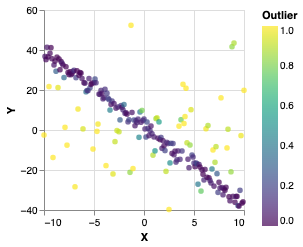

In [30]:
plotVega  $ take 5000 (zip (fst <$> samples) (outlierProb mhRuns))

Running MCMC gives us a list of samples. The graph displays points as more opaque according to how many samples consider that point to not be an outlier. The results make sense: points that are very near the line are opaque and ones very far are transparent. 

It would be nice to make our approach more sample efficient though. The key to that is to choose a proposal distribution more cleverly. 

In [20]:
-- import Numeric.Log

-- countOutliersWithWeight :: [((a, [Bool]), Log Double)] -> [(Double, Double)]
-- countOutliersWithWeight = foldr 
--     (\((_,lb),w) li -> 
--         [ if b then (num1+ 1, num2) else (num1,num2+ 1) | ((b),(num1, num2)) <- zip lb li]) 
--     (Prelude.repeat (0,0))

-- predData = baseData . 
--   dataColumn "Outlier Prediction" 
--       -- (Booleans $ (\((_,s),_) -> s) (maximumBy (compare `on` (snd)) smcRuns))
--       (Booleans ((\(x, y) -> ( if x > y then False else True) )
--         <$> (countOutliers (fst <$> smcRuns))))
  
-- predEncoding = baseEncoding . color [ MName "Outlier Prediction", VL.MmType VL.Quantitative]
-- showPlot predEncoding predData